In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json
from glob import glob

In [3]:
torch.backends.cudnn.benchmark=True

## Data

In [4]:
PATH = Path('../data/Train')

In [5]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [26]:
VEHICLES=10
ROADS=7

### Create dataloader

In [27]:
def convert_y(y_img):
    y_new = np.zeros(y_img.shape)
    y_new[y_img[:,:,2]==VEHICLES] = 1
    y_new[y_img[:,:,2]==ROADS] = 2
    return y_new.astype(np.int64)

In [28]:
def open_y_image(fn):
    """ Opens an image using OpenCV given the file path.

    Arguments:
        fn: the file path of the image

    Returns:
        The image in RGB format as numpy array of floats normalized to range between 0.0 - 1.0
    """
    flags = cv2.IMREAD_UNCHANGED+cv2.IMREAD_ANYDEPTH+cv2.IMREAD_ANYCOLOR
    if not os.path.exists(fn):
        raise OSError('No such file or directory: {}'.format(fn))
    elif os.path.isdir(fn):
        raise OSError('Is a directory: {}'.format(fn))
    else:
        try:
            im = cv2.imread(str(fn), flags)
            if im is None: raise OSError(f'File not recognized by opencv: {fn}')
            return convert_y(im)
        except Exception as e:
            raise OSError('Error handling image at: {}'.format(fn)) from e

In [8]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): 
        return open_y_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 3
    def get(self, tfm, x, y):
        x,y = super().get(tfm, x, y)
        return x,y[0]

In [9]:
def get_data(train_path, mask_path, bs):
    x_names = np.array(glob(str(PATH/TRAIN_DN/'*.png')))
    y_names = np.array(glob(str(PATH/MASKS_DN/'*.png')))
    print(len(x_names), len(y_names))
    val_idxs = list(range(100))
    ((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)
    aug_tfms = [
        RandomRotate(4, tfm_y=TfmType.CLASS),
        RandomFlip(tfm_y=TfmType.CLASS),
        RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)
    ]
    tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path='')
    md = ImageData(PATH, datasets, bs, num_workers=7, classes=None)
    denorm = md.trn_ds.denorm
    return md

In [10]:
def new_acc(preds, targs):
    mx,idx = torch.max(preds, 1)
    return (idx == targs).float().mean()
def dice(pred, targs):
#     pred = (pred>0).float()
    mx,idx = torch.max(pred, 1)
    pred = idx.float()
    targs = targs.float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

## Simple upsample

In [11]:
f = resnet34
cut,lr_cut = model_meta[f]

In [12]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

## U-net (ish)

In [13]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [14]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [15]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = UnetBlock(256,3,16)
        self.up6 = nn.ConvTranspose2d(16, 3, 1)
        
    def forward(self,x):
        inp = x
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x, inp)
        x = self.up6(x)
        return x
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [16]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [17]:
def get_learner(md):
    m_base = get_base()
    m = to_gpu(Unet34(m_base))
    models = UnetModel(m)
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    learn.crit=nn.CrossEntropyLoss()
    learn.metrics=[new_acc, dice]
    return learn

In [14]:
TRAIN_DN = 'CameraRGB-128'
MASKS_DN = 'CameraSeg-128'
sz = 128
bs = 64

In [15]:
md = get_data(TRAIN_DN, MASKS_DN, bs)

1000 1000


In [57]:
learn = get_learner(md)

In [32]:
learn.freeze_to(1)

epoch      trn_loss   val_loss   new_acc    dice           
    0      1.376398   1.288309090403628e+22 0.25086    0.818061  



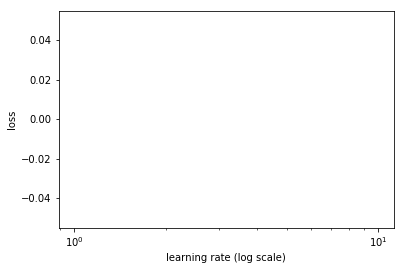

In [33]:
learn.lr_find()
learn.sched.plot()

In [34]:
lr=4e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [35]:
learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8))

epoch      trn_loss   val_loss   new_acc    dice           
    0      0.525234   38.486424  0.238146   0.83136   
    1      0.281099   1.050142   0.799626   1.349154       
    2      0.19594    0.092219   0.968301   1.614889       
    3      0.147314   0.049939   0.981608   1.653288       
    4      0.116769   0.040435   0.985997   1.666588       
    5      0.096055   0.039207   0.986831   1.666813        
    6      0.081463   0.03184    0.989436   1.672833        
    7      0.070177   0.028616   0.990396   1.675053        



[array([0.02862]), 0.9903961181640625, 1.6750532691533686]

In [36]:
learn.save('128urn-tmp')

In [112]:
learn.load('128urn-tmp')

In [37]:
learn.unfreeze()
learn.bn_freeze(True)

In [38]:
learn.fit(lrs/2, 1, wds=wd, cycle_len=10,use_clr=(20,10))

epoch      trn_loss   val_loss   new_acc    dice            
    0      0.041288   0.02772    0.990304   1.67503   
    1      0.040122   0.027758   0.99007    1.67468         
    2      0.039955   0.02477    0.991401   1.676934        
    3      0.038411   0.024383   0.991418   1.677613        
    4      0.03726    0.024192   0.991895   1.677639        
    5      0.036002   0.022385   0.99225    1.679353        
    6      0.035137   0.021896   0.992441   1.679661        
    7      0.034784   0.022052   0.99239    1.679329        
    8      0.034144   0.02164    0.992505   1.679673        
    9      0.033929   0.021664   0.992582   1.6802          



[array([0.02166]), 0.9925824069976806, 1.680200434222037]

In [39]:
learn.save('128urn-0')

In [116]:
learn.load('128urn-0')

In [40]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [41]:
py = np.argmax(py,1)

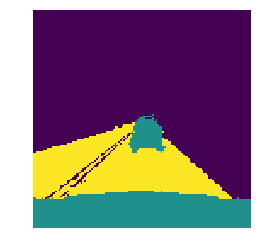

In [42]:
show_img(py[0]);

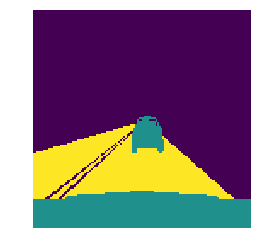

In [43]:
show_img(y[0]);

In [44]:
m.close()

## 256x256

In [59]:
TRAIN_DN = 'CameraRGB-256'
MASKS_DN = 'CameraSeg-256'
sz=256
bs=64

In [60]:
md = get_data(TRAIN_DN, MASKS_DN, bs)

1000 1000


In [61]:
lr=2e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [62]:
learn = get_learner(md)

In [63]:
learn.freeze_to(1)

In [66]:
learn.load('128urn-0')

In [67]:
learn.fit(lr,1,wds=wd, cycle_len=10,use_clr=(5,5))

epoch      trn_loss   val_loss   new_acc    dice           
    0      0.113522   0.0451     0.984932   1.665489  
    1      0.079923   0.033007   0.98884    1.669157        
    2      0.062774   0.025787   0.991372   1.676283        
    3      0.052378   0.02275    0.992448   1.678694        
    4      0.045408   0.021506   0.992789   1.68014         
    5      0.040281   0.019352   0.993639   1.680822        
    6      0.036301   0.019224   0.993382   1.68021         
    7      0.033314   0.017174   0.994198   1.681906        
    8      0.030933   0.016736   0.994292   1.682233        
    9      0.029014   0.015931   0.994617   1.682869        



[array([0.01593]), 0.9946173048019409, 1.6828691908967912]

In [70]:
learn.save('256urn-tmp')

In [71]:
learn.unfreeze()
learn.bn_freeze(True)

In [72]:
learn.load('256urn-tmp')

In [73]:
learn.fit(lrs/2,1,wds=wd, cycle_len=8,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    dice            
    0      0.023397   0.015959   0.994397   1.682657  
    1      0.023117   0.015586   0.994512   1.681203        
    2      0.022476   0.015034   0.994721   1.681997        
    3      0.022427   0.014449   0.994915   1.682736        
    4      0.022139   0.014395   0.99498    1.683078        
    5      0.021749   0.014163   0.995045   1.683939        
    6      0.021521   0.014033   0.995086   1.683462        
    7      0.021235   0.013922   0.99514    1.683642        



[array([0.01392]), 0.9951400828361511, 1.6836421391515495]

In [75]:
learn.save('256urn')

In [76]:
learn.load('256urn')

In [77]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [78]:
py = np.argmax(py,1)

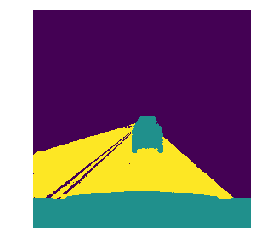

In [79]:
show_img(py[0]);

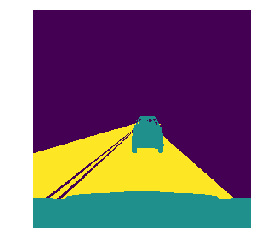

In [80]:
show_img(y[0]);

In [81]:
m.close()

## 512x512

In [29]:
TRAIN_DN = 'CameraRGB'
MASKS_DN = 'CameraSeg'
sz=512
bs=16

In [30]:
md = get_data(TRAIN_DN, MASKS_DN, bs)

1000 1000


In [31]:
learn = get_learner(md)

In [32]:
learn.load('256urn')

In [33]:
learn.freeze_to(1)

In [34]:
lr=4e-2
wd=1e-7

lrs = np.array([lr/200,lr/20,lr])/2

In [35]:
learn.fit(lr,1, wds=wd, cycle_len=2,use_clr=(5,4))

epoch      trn_loss   val_loss   new_acc    dice            
    0      0.047214   0.030178   0.989105   1.666617  
    1      0.030979   0.019455   0.992572   1.680972        



[array([0.01945]), 0.9925720596313476, 1.680972326568866]

In [36]:
learn.save('600urn-tmp')

In [37]:
learn.load('600urn-tmp')

In [38]:
learn.unfreeze()
learn.bn_freeze(True)

In [39]:
lrs = np.array([lr/200,lr/30,lr])

In [40]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    dice            
    0      0.021994   0.015334   0.994312   1.683506  
    1      0.020949   0.014402   0.994584   1.684134        
    2      0.019796   0.014147   0.994657   1.684026        
    3      0.019298   0.013925   0.994744   1.684283        



[array([0.01392]), 0.9947436904907226, 1.6842833877869254]

In [43]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   new_acc    dice            
    0      0.01883    0.013766   0.994776   1.684419  
    1      0.018683   0.013265   0.994909   1.683993        
    2      0.018177   0.012954   0.995019   1.685037        
    3      0.017524   0.012945   0.995024   1.684988        



[array([0.01295]), 0.9950236892700195, 1.6849875769550504]

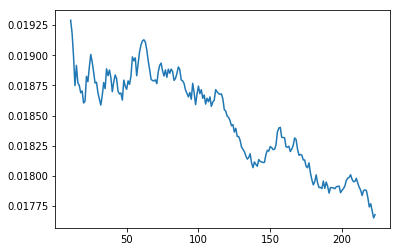

In [44]:
learn.sched.plot_loss()

In [45]:
learn.save('1024urn')

In [ ]:
learn.load('1024urn')

In [ ]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

In [ ]:
show_img(py[0]>0);

In [ ]:
show_img(y[0]);